Starting comprehensive polynomial degree analysis...
Starting systematic error analysis across polynomial degrees 1-100...
This may take a few minutes...
Processing ReLU...
Processing Sigmoid...
Processing Tanh...
Processing GELU...
Processing SiLU...
Processing Mish...
Processing LeakyReLU...
Processing Softplus...
Processing Softmax...

Generating error analysis plots...


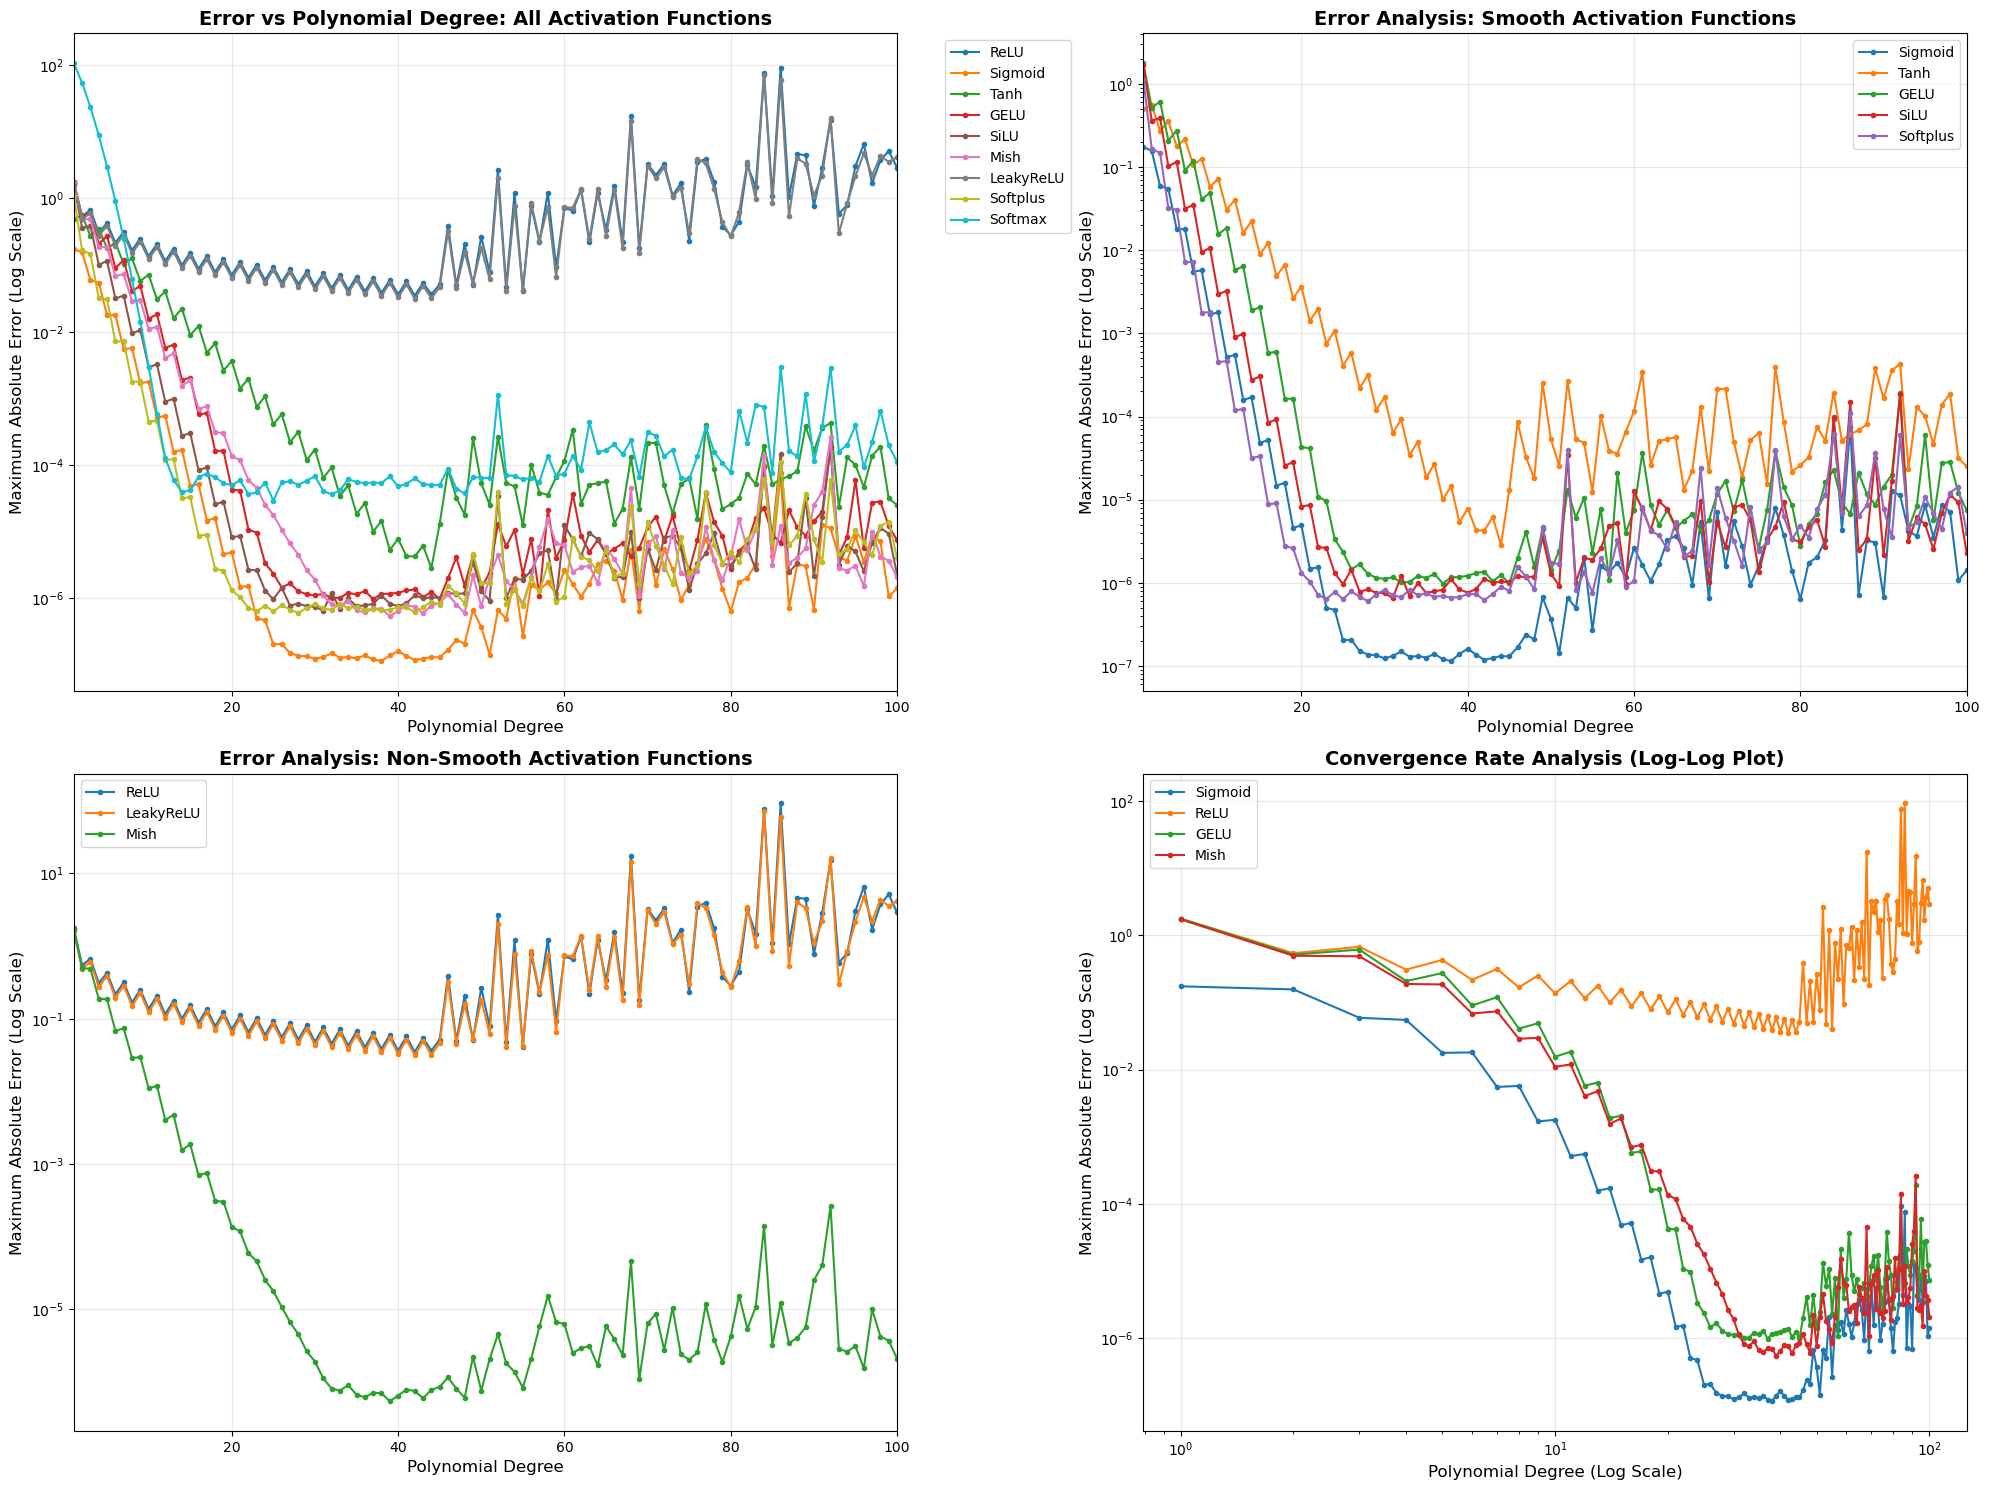


ERROR ANALYSIS SUMMARY
Function        Min Error    @ Degree   Error @ 50   Error @ 100 
--------------------------------------------------------------------------------
ReLU            3.48e-02     42         2.68e-01     2.90e+00    
Sigmoid         1.15e-07     38         3.69e-07     1.41e-06    
Tanh            2.85e-06     44         5.30e-05     2.52e-05    
GELU            9.80e-07     37         1.43e-06     7.46e-06    
SiLU            6.54e-07     31         1.29e-06     2.29e-06    
Mish            5.42e-07     39         7.61e-07     2.09e-06    
LeakyReLU       3.15e-02     42         1.82e-01     4.17e+00    
Softplus        6.02e-07     28         1.71e-06     3.99e-06    
Softmax         2.93e-05     25         6.47e-05     1.11e-04    

Generating Chebyshev interpolation comparison plots...


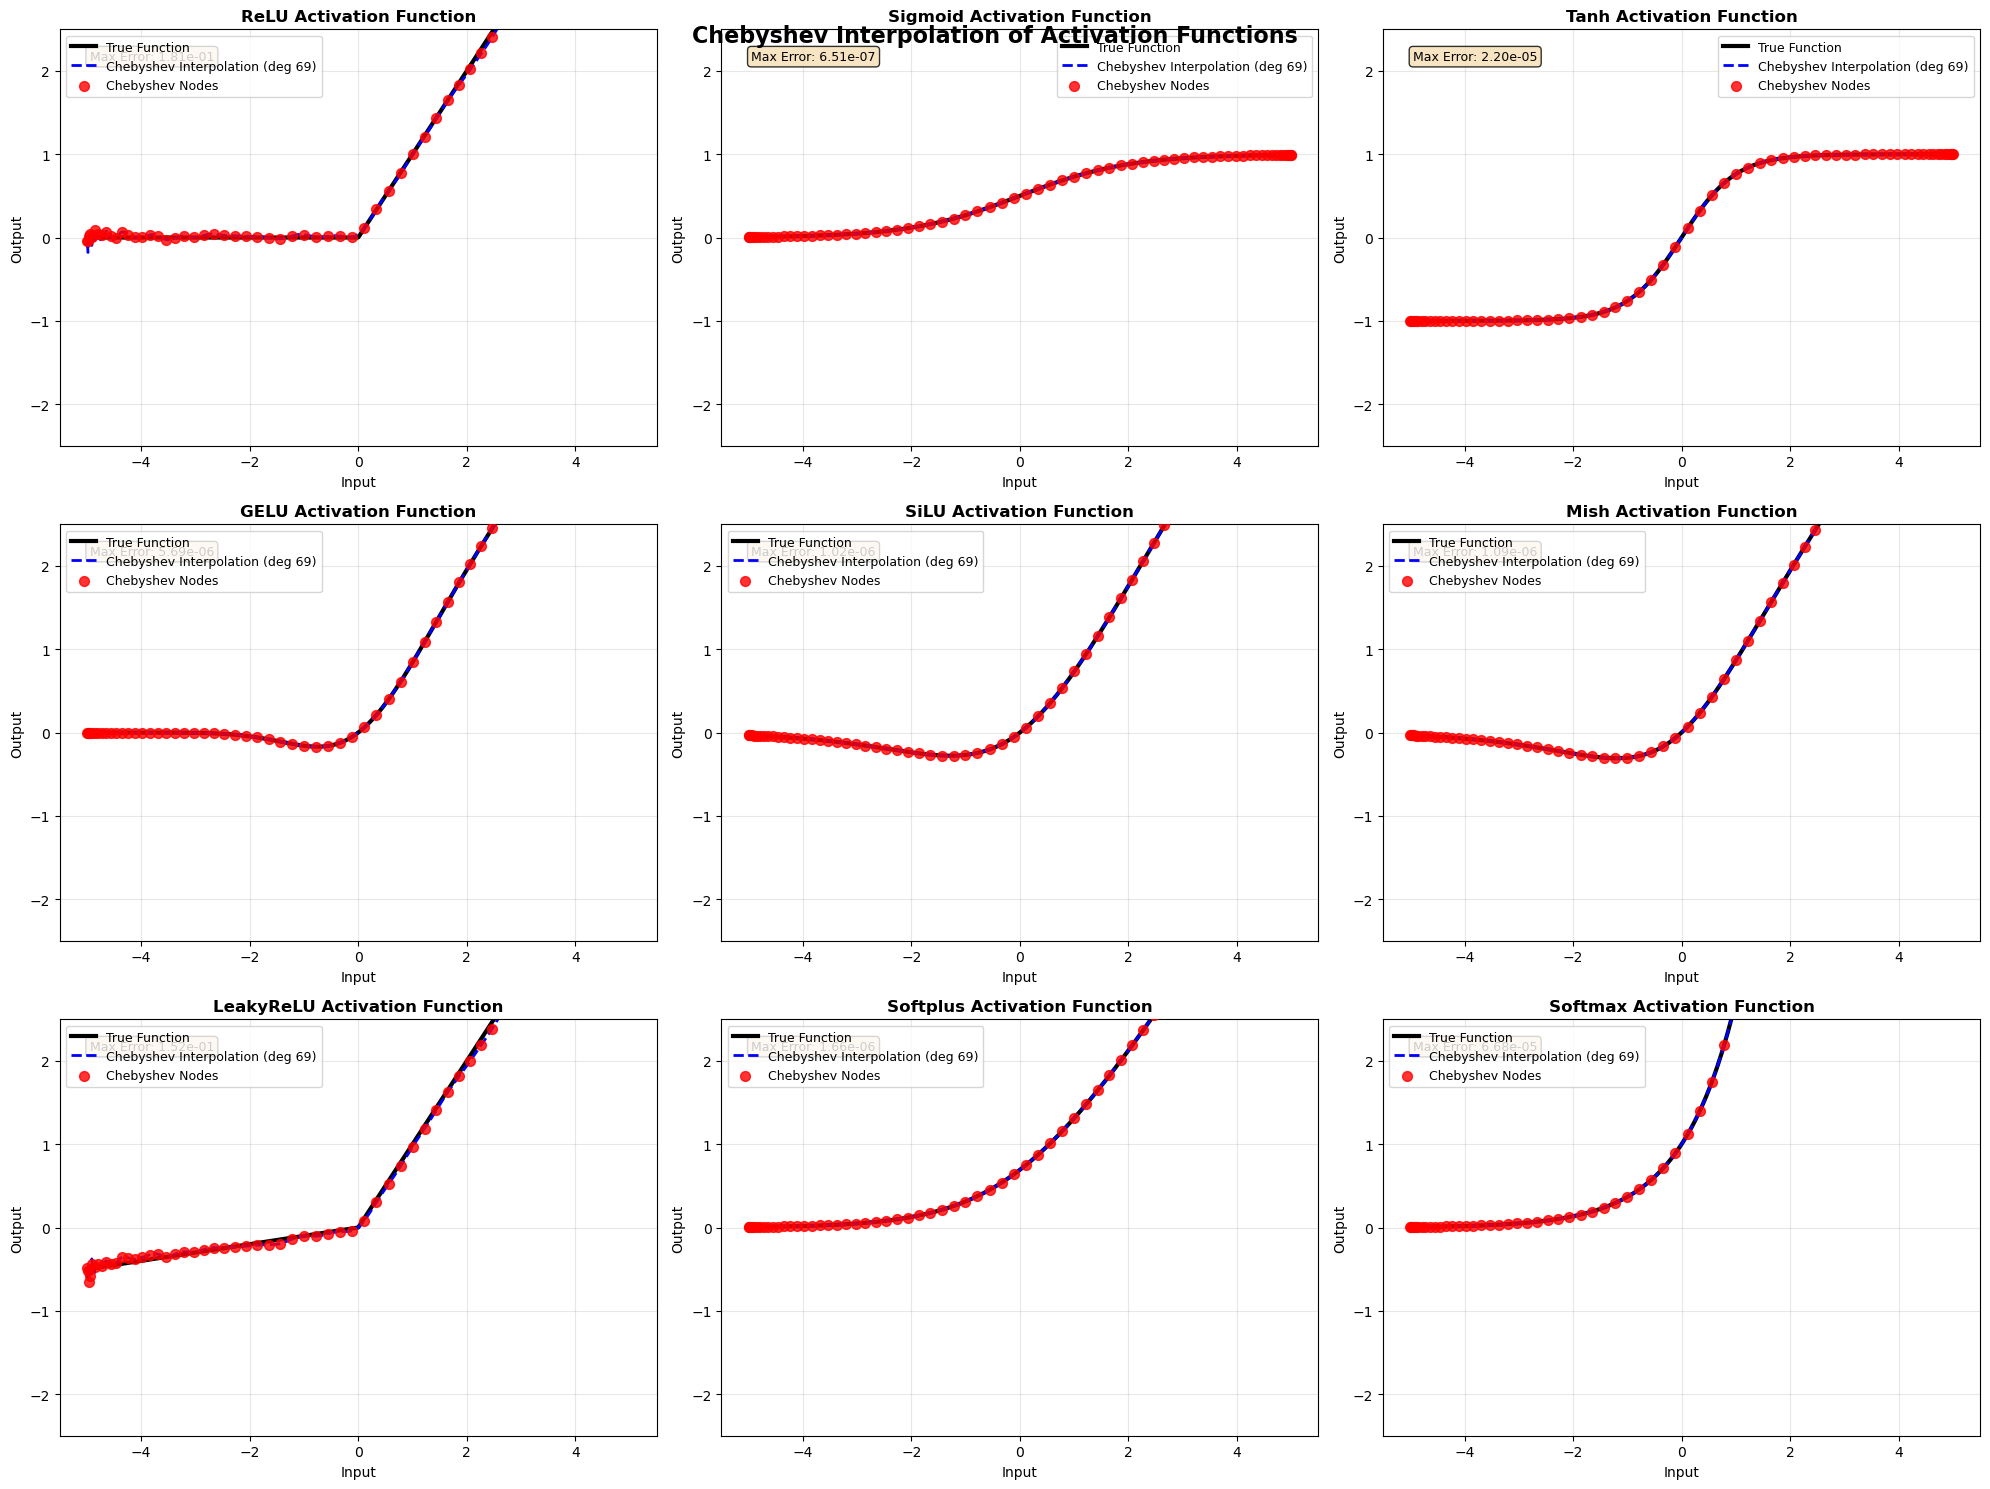


Analysis complete!


In [ ]:
# Curvefitting the Activation Functions using a Chebyshev High Degree Polynomials using the Chebyshev Nodes to Avoid the Runge Phenomenom...
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error

class ChebyshevActivationInterpolator:
    """Chebyshev polynomial interpolator for activation functions to avoid Runge phenomenon"""
    
    def __init__(self, expansion_point=0.0):
        self.expansion_point = expansion_point
        self.coefficients = None
        self.degree = None
        self.x_train = None
        
    def _generate_chebyshev_nodes(self, a, b, n):
        """Generate Chebyshev nodes of the first kind on interval [a, b]"""
        i = np.arange(n)
        # Chebyshev nodes formula: cos((2k+1)π/(2n))
        nodes_unit = np.cos((2 * i + 1) * np.pi / (2 * n))
        # Transform from [-1, 1] to [a, b]
        return 0.5 * (b - a) * nodes_unit + 0.5 * (b + a)
    
    def _vandermonde_matrix(self, x, degree):
        """Construct shifted Vandermonde matrix with specified degree"""
        x_shifted = x - self.expansion_point
        return np.vander(x_shifted, N=degree+1, increasing=True)
    
    def fit(self, activation_fn, x_range=(-5, 5), n_points=50):
        """Fit exact interpolating polynomial using Chebyshev nodes"""
        # Generate Chebyshev nodes instead of equally spaced points
        self.x_train = self._generate_chebyshev_nodes(x_range[0], x_range[1], n_points)
        
        # Evaluate activation function at Chebyshev nodes
        x_torch = torch.tensor(self.x_train, dtype=torch.float32).unsqueeze(-1)
        y_train = activation_fn(x_torch).numpy().flatten()
        
        self.degree = len(self.x_train) - 1  # Exact degree for interpolation
        X = self._vandermonde_matrix(self.x_train, self.degree)
        
        # Solve for exact coefficients using Chebyshev node data
        self.coefficients = np.linalg.solve(X, y_train)
        return self
    
    def predict(self, x):
        """Evaluate interpolating polynomial"""
        X = self._vandermonde_matrix(x, self.degree)
        return X @ self.coefficients
    
    def calculate_metrics(self, x_test, y_true):
        """Calculate evaluation metrics for the interpolation"""
        y_pred = self.predict(x_test)
        return {
            'MSE': mean_squared_error(y_true, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'MAE': mean_absolute_error(y_true, y_pred),
            'R²': r2_score(y_true, y_pred),
            'Max Error': max_error(y_true, y_pred)
        }

# Define all PyTorch activation functions
activation_config = {
    'ReLU': F.relu,
    'Sigmoid': torch.sigmoid,
    'Tanh': torch.tanh,
    'GELU': F.gelu,
    'SiLU': F.silu,
    'Mish': lambda x: x * torch.tanh(F.softplus(x)),
    'LeakyReLU': lambda x: F.leaky_relu(x, 0.1),
    'Softplus': F.softplus,
    # 'ELU': lambda x: F.elu(x, 1.0)
    'Softmax': lambda x: torch.exp(x)
}

def analyze_error_vs_degree():
    """Analyze interpolation error vs polynomial degree from 1 to 100"""
    degrees = range(1, 101)
    x_range = (-5, 5)
    
    # Create test data once
    x_test = np.linspace(x_range[0], x_range[1], 1000)
    
    # Storage for results
    error_results = {}
    
    print("Starting systematic error analysis across polynomial degrees 1-100...")
    print("This may take a few minutes...")
    
    for name, fn in activation_config.items():
        print(f"Processing {name}...")
        
        # Evaluate true function
        x_torch = torch.tensor(x_test, dtype=torch.float32)
        y_true = fn(x_torch).numpy()
        
        max_errors = []
        
        for degree in degrees:
            try:
                # Create interpolator with specified degree (degree + 1 points)
                interpolator = ChebyshevActivationInterpolator()
                interpolator.fit(fn, x_range=x_range, n_points=degree + 1)
                
                # Calculate prediction and error
                y_pred = interpolator.predict(x_test)
                max_error = np.max(np.abs(y_true - y_pred))
                max_errors.append(max_error)
                
            except (np.linalg.LinAlgError, RuntimeError):
                # Handle numerical instability for very high degrees
                max_errors.append(np.inf)
        
        error_results[name] = max_errors
    
    return degrees, error_results

def plot_error_analysis(degrees, error_results):
    """Plot comprehensive error analysis"""
    
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(20, 15))
    
    # Main plot: All activation functions on log scale
    ax1 = plt.subplot(2, 2, 1)
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(activation_config)))
    
    for i, (name, errors) in enumerate(error_results.items()):
        # Replace inf values with NaN for plotting
        plot_errors = [e if e != np.inf else np.nan for e in errors]
        ax1.semilogy(degrees, plot_errors, '-o', color=colors[i], 
                    label=name, markersize=3, linewidth=1.5)
    
    ax1.set_xlabel('Polynomial Degree', fontsize=12)
    ax1.set_ylabel('Maximum Absolute Error (Log Scale)', fontsize=12)
    ax1.set_title('Error vs Polynomial Degree: All Activation Functions', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    ax1.set_xlim(1, 100)
    
    # Subplot 2: Focus on smooth functions
    ax2 = plt.subplot(2, 2, 2)
    smooth_functions = ['Sigmoid', 'Tanh', 'GELU', 'SiLU', 'Softplus']
    
    for name in smooth_functions:
        if name in error_results:
            errors = error_results[name]
            plot_errors = [e if e != np.inf else np.nan for e in errors]
            ax2.semilogy(degrees, plot_errors, '-o', label=name, markersize=3, linewidth=1.5)
    
    ax2.set_xlabel('Polynomial Degree', fontsize=12)
    ax2.set_ylabel('Maximum Absolute Error (Log Scale)', fontsize=12)
    ax2.set_title('Error Analysis: Smooth Activation Functions', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=10)
    ax2.set_xlim(1, 100)
    
    # Subplot 3: Focus on non-smooth functions
    ax3 = plt.subplot(2, 2, 3)
    nonsmooth_functions = ['ReLU', 'LeakyReLU', 'ELU', 'Mish']
    
    for name in nonsmooth_functions:
        if name in error_results:
            errors = error_results[name]
            plot_errors = [e if e != np.inf else np.nan for e in errors]
            ax3.semilogy(degrees, plot_errors, '-o', label=name, markersize=3, linewidth=1.5)
    
    ax3.set_xlabel('Polynomial Degree', fontsize=12)
    ax3.set_ylabel('Maximum Absolute Error (Log Scale)', fontsize=12)
    ax3.set_title('Error Analysis: Non-Smooth Activation Functions', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.legend(fontsize=10)
    ax3.set_xlim(1, 100)
    
    # Subplot 4: Convergence rate analysis
    ax4 = plt.subplot(2, 2, 4)
    
    # Show convergence regions
    selected_functions = ['Sigmoid', 'ReLU', 'GELU', 'Mish']
    
    for name in selected_functions:
        if name in error_results:
            errors = error_results[name]
            # Only plot finite errors
            finite_errors = [(d, e) for d, e in zip(degrees, errors) if e != np.inf and e > 0]
            if finite_errors:
                d_finite, e_finite = zip(*finite_errors)
                ax4.loglog(d_finite, e_finite, '-o', label=name, markersize=3, linewidth=1.5)
    
    ax4.set_xlabel('Polynomial Degree (Log Scale)', fontsize=12)
    ax4.set_ylabel('Maximum Absolute Error (Log Scale)', fontsize=12)
    ax4.set_title('Convergence Rate Analysis (Log-Log Plot)', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    ax4.legend(fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def print_error_summary(degrees, error_results):
    """Print summary statistics for error analysis"""
    
    print("\n" + "="*80)
    print("ERROR ANALYSIS SUMMARY")
    print("="*80)
    
    print(f"{'Function':<15} {'Min Error':<12} {'@ Degree':<10} {'Error @ 50':<12} {'Error @ 100':<12}")
    print("-"*80)
    
    for name, errors in error_results.items():
        finite_errors = [e for e in errors if e != np.inf]
        
        if finite_errors:
            min_error = min(finite_errors)
            min_degree = errors.index(min_error) + 1
            error_50 = errors[49] if len(errors) > 49 and errors[49] != np.inf else "N/A"
            error_100 = errors[99] if len(errors) > 99 and errors[99] != np.inf else "N/A"
            
            print(f"{name:<15} {min_error:<12.2e} {min_degree:<10} {error_50 if error_50 == 'N/A' else f'{error_50:.2e}':<12} {error_100 if error_100 == 'N/A' else f'{error_100:.2e}':<12}")

def compare_interpolation_methods():
    """Compare Chebyshev vs equally spaced interpolation"""
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    axes = axes.flatten()
    
    for idx, (name, fn) in enumerate(activation_config.items()):
        ax = axes[idx]
        
        # Chebyshev interpolation
        cheb_interpolator = ChebyshevActivationInterpolator()
        cheb_interpolator.fit(fn, x_range=(-5, 5), n_points=70)
        
        # Generate test data
        x_test = np.linspace(-5, 5, 1000)
        x_torch = torch.tensor(x_test, dtype=torch.float32)
        y_true = fn(x_torch).numpy()
        y_cheb = cheb_interpolator.predict(x_test)
        
        # Plot results
        ax.plot(x_test, y_true, label='True Function', linewidth=3, color='black')
        ax.plot(x_test, y_cheb, '--', label=f'Chebyshev Interpolation (deg {cheb_interpolator.degree})', 
                linewidth=2, color='blue')
        
        # Mark Chebyshev nodes
        cheb_nodes = cheb_interpolator.x_train
        cheb_values = cheb_interpolator.predict(cheb_nodes)
        ax.scatter(cheb_nodes, cheb_values, color='red', s=50, zorder=5, 
                  label='Chebyshev Nodes', alpha=0.8)
        
        ax.set_title(f"{name} Activation Function", fontweight='bold', fontsize=12)
        ax.set_xlabel("Input", fontsize=10)
        ax.set_ylabel("Output", fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=9)
        ax.set_ylim([-2.5, 2.5])
        
        # Calculate and display maximum error
        max_error_val = np.max(np.abs(y_true - y_cheb))
        ax.text(0.05, 0.95, f'Max Error: {max_error_val:.2e}', transform=ax.transAxes, 
                fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.suptitle("Chebyshev Interpolation of Activation Functions", 
                 y=0.98, fontsize=16, fontweight='bold')
    plt.show()

if __name__ == "__main__":
    print("Starting comprehensive polynomial degree analysis...")
    print("="*80)
    
    # Run the error vs degree analysis
    degrees, error_results = analyze_error_vs_degree()
    
    # Create comprehensive plots
    print("\nGenerating error analysis plots...")
    plot_error_analysis(degrees, error_results)
    
    # Print summary statistics
    print_error_summary(degrees, error_results)
    
    print("\n" + "="*80)
    print("Generating Chebyshev interpolation comparison plots...")
    compare_interpolation_methods()
    
    print("\nAnalysis complete!")
    print("="*80)


Starting dual-domain interpolation...

ReLU Piecewise Chebyshev Polynomials:
Negative Domain (x < 0):

Positive Domain (x >= 0):
0.0000000142050091520299699614523185201356292317598217778140679001808166503906250000000000000000000000 + 0.9999994929195844539648874160775449126958847045898437500000000000000000000000000000000000000000000000(x-0.0) + 0.0000025493746351880592037860220888667583949427353218197822570800781250000000000000000000000000000000(x-0.0)^2 - 0.0000049984424703889824935639993319647089720092481002211570739746093750000000000000000000000000000000(x-0.0)^3 + 0.0000047887180370682823848070552852362880003056488931179046630859375000000000000000000000000000000000(x-0.0)^4 - 0.0000024868090843972779117269228388309443289472255855798721313476562500000000000000000000000000000000(x-0.0)^5 + 0.0000007308157380224438056087049586651005483872722834348678588867187500000000000000000000000000000000(x-0.0)^6 - 0.0000001204075449640056186196619301617682928906560846371576189994812011718750000000

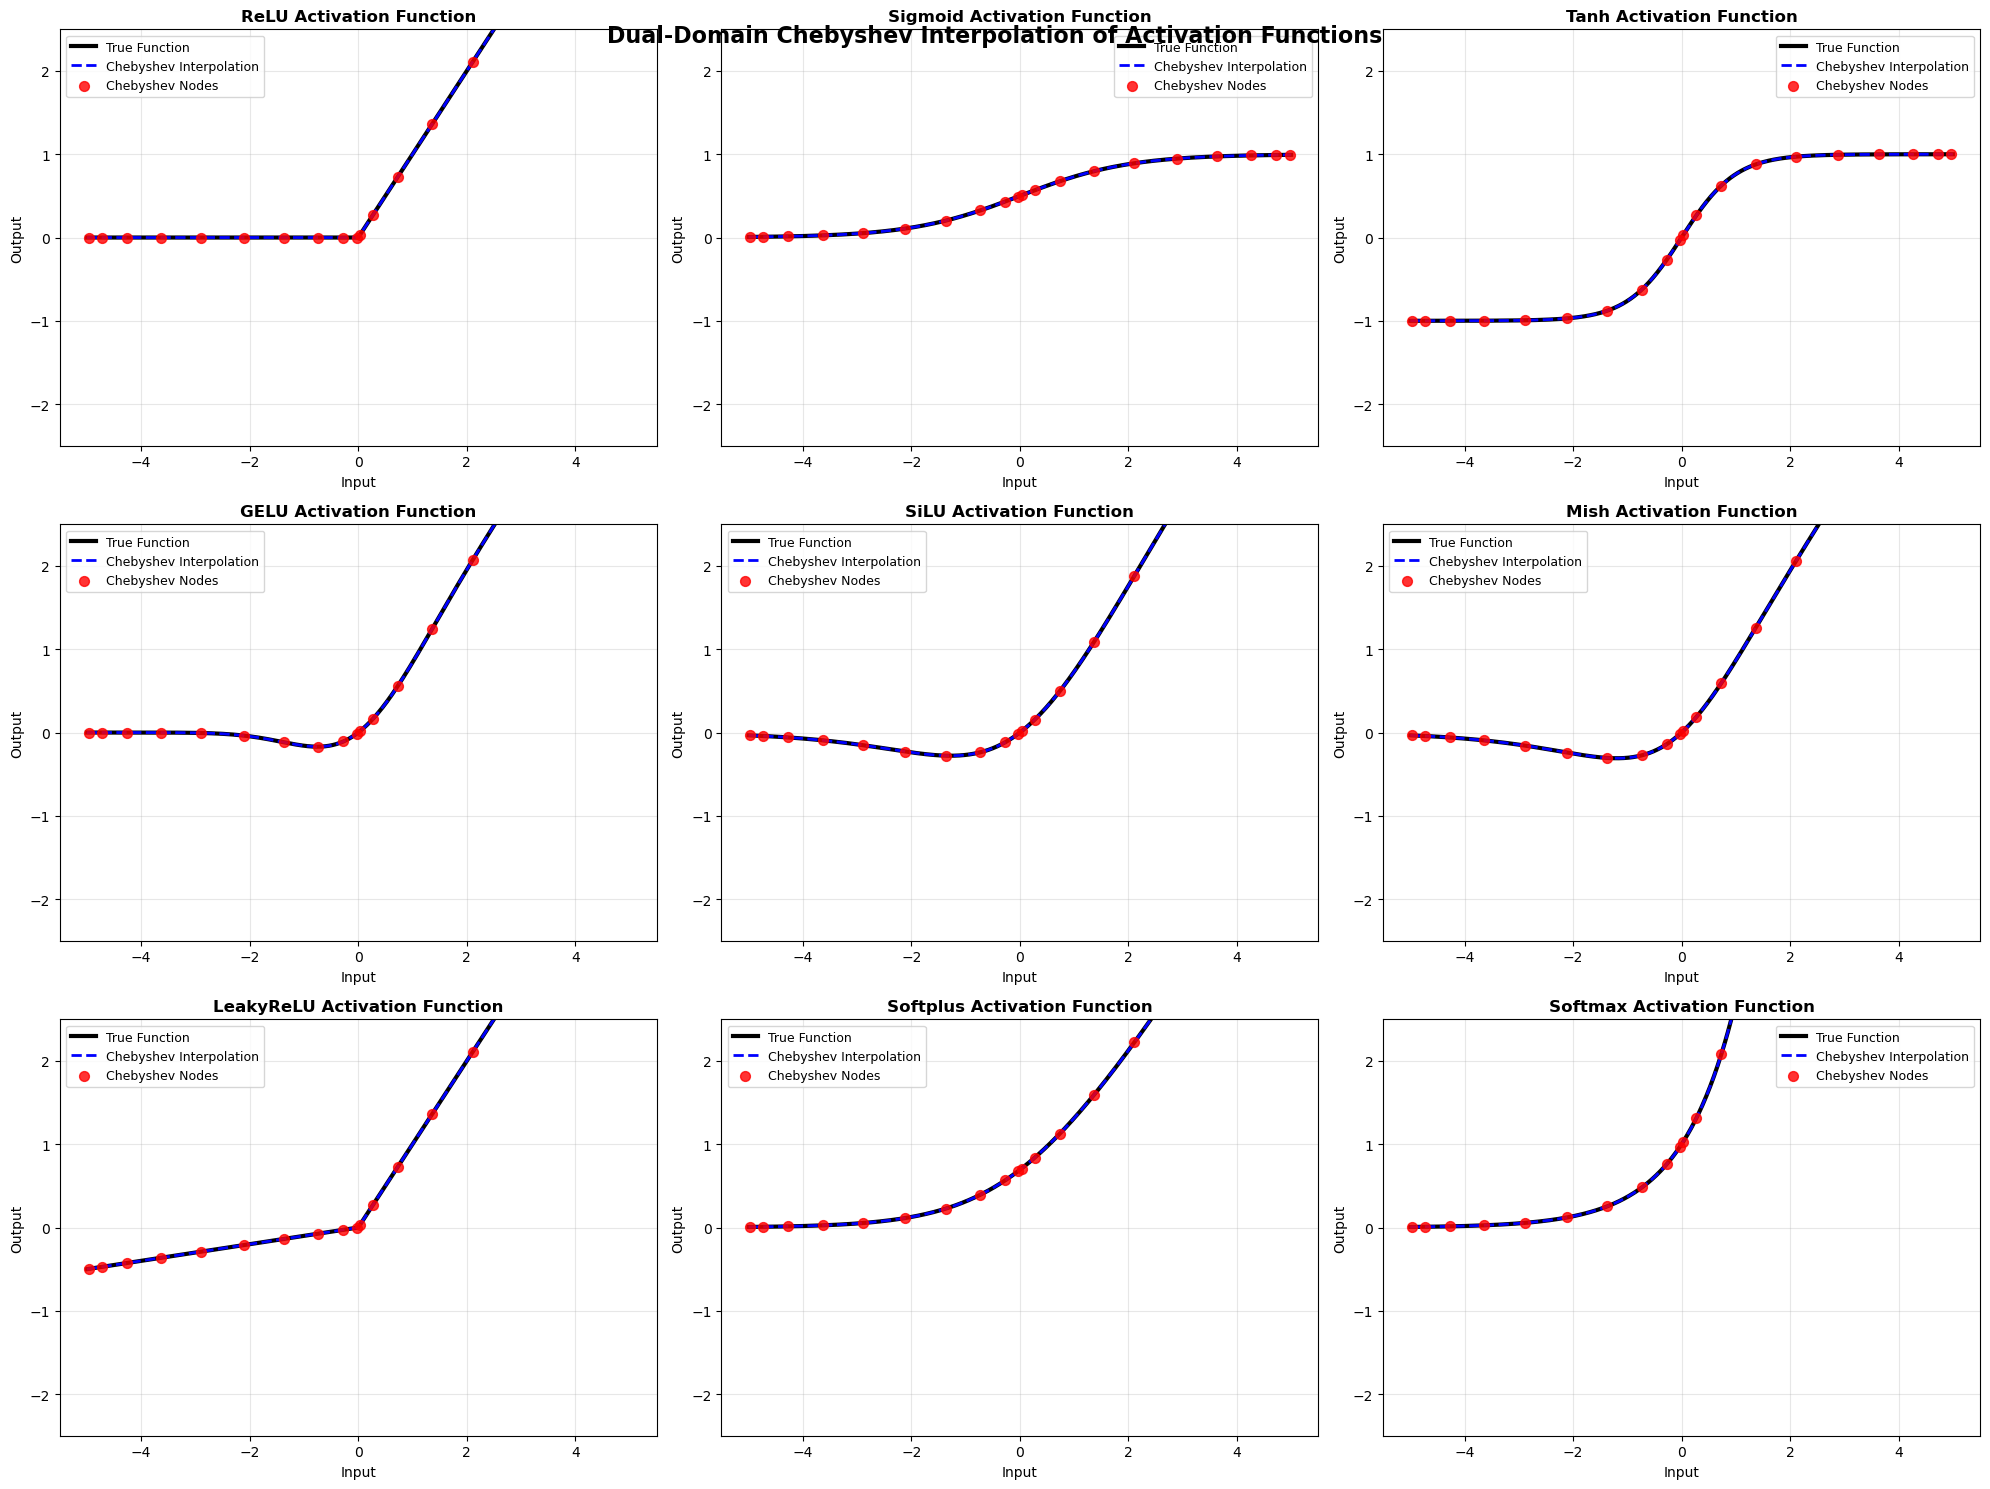

In [ ]:
# Piecewise Seperate Polynomials for Positive and Negative Domains of the Activation Functions
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error

class ChebyshevActivationInterpolator:
    """Chebyshev polynomial interpolator for activation functions with dual-domain support"""
    
    def __init__(self, expansion_point=0.0):
        self.expansion_point = expansion_point
        self.coefficients = None
        self.degree = None
        self.x_train = None
        
    def _generate_chebyshev_nodes(self, a, b, n):
        """Generate Chebyshev nodes of the first kind on interval [a, b]"""
        i = np.arange(n)
        nodes_unit = np.cos((2 * i + 1) * np.pi / (2 * n))
        return 0.5 * (b - a) * nodes_unit + 0.5 * (b + a)
    def get_chebyshev_nodes(self):
        """Retrieve stored Chebyshev nodes"""
        return self.x_train.copy()
    def _vandermonde_matrix(self, x, degree):
        """Construct shifted Vandermonde matrix with specified degree"""
        x_shifted = x - self.expansion_point
        return np.vander(x_shifted, N=degree+1, increasing=True)
    
    def fit(self, activation_fn, x_range=(-5, 5), n_points=50):
        """Fit exact interpolating polynomial using Chebyshev nodes"""
        self.x_train = self._generate_chebyshev_nodes(x_range[0], x_range[1], n_points)
        
        x_torch = torch.tensor(self.x_train, dtype=torch.float32).unsqueeze(-1)
        y_train = activation_fn(x_torch).numpy().flatten()
        
        self.degree = len(self.x_train) - 1
        X = self._vandermonde_matrix(self.x_train, self.degree)
        
        self.coefficients = np.linalg.solve(X, y_train)
        return self
    
    def predict(self, x):
        """Evaluate interpolating polynomial"""
        X = self._vandermonde_matrix(x, self.degree)
        return X @ self.coefficients
    
    def equation(self, precision=100):
        """Generate formatted polynomial equation"""
        terms = []
        for i, coeff in enumerate(self.coefficients):
            if abs(coeff) < 1e-10:
                continue
            term = f"{coeff:.{precision}f}"
            if i > 0:
                term += f"(x-{self.expansion_point})^{i}" if i > 1 else f"(x-{self.expansion_point})"
            terms.append(term)
        return " + ".join(terms).replace("+ -", "- ")

# Activation function configuration
activation_config = {
    'ReLU': F.relu,
    'Sigmoid': torch.sigmoid,
    'Tanh': torch.tanh,
    'GELU': F.gelu,
    'SiLU': F.silu,
    'Mish': lambda x: x * torch.tanh(F.softplus(x)),
    'LeakyReLU': lambda x: F.leaky_relu(x, 0.1),
    'Softplus': F.softplus,
    'Softmax': lambda x: torch.exp(x)
}

def compare_interpolation_methods():
    """Compare Chebyshev vs equally spaced interpolation with dual-domain support"""
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    axes = axes.flatten()
    
    for idx, (name, fn) in enumerate(activation_config.items()):
        ax = axes[idx]
        
        # Create dual interpolators
        interp_neg = ChebyshevActivationInterpolator()
        interp_pos = ChebyshevActivationInterpolator()
        
        # Fit on respective domains
        interp_neg.fit(fn, x_range=(-5, 0), n_points=10)
        interp_pos.fit(fn, x_range=(0, 5), n_points=10)

        # Generate test data
        x_test = np.linspace(-5, 5, 1000)
        x_neg = x_test[x_test < 0]
        x_pos = x_test[x_test >= 0]
        
        # Get predictions
        y_cheb_neg = interp_neg.predict(x_neg)
        y_cheb_pos = interp_pos.predict(x_pos)
        y_cheb = np.concatenate([y_cheb_neg, y_cheb_pos])
        
        # Get true values
        y_true = fn(torch.tensor(x_test, dtype=torch.float32)).numpy()
        
        # Plot results
        ax.plot(x_test, y_true, label='True Function', linewidth=3, color='black')
        ax.plot(x_test, y_cheb, '--', label=f'Chebyshev Interpolation', linewidth=2, color='blue')
        
        # Plot nodes
        nodes_neg = interp_neg.get_chebyshev_nodes()
        nodes_pos = interp_pos.get_chebyshev_nodes()
        ax.scatter(nodes_neg, fn(torch.tensor(nodes_neg, dtype=torch.float32)), 
                  color='red', s=50, zorder=5, label='Chebyshev Nodes', alpha=0.8)
        ax.scatter(nodes_pos, fn(torch.tensor(nodes_pos, dtype=torch.float32)), 
                  color='red', s=50, zorder=5, alpha=0.8)

        ax.set_title(f"{name} Activation Function", fontweight='bold', fontsize=12)
        ax.set_xlabel("Input", fontsize=10)
        ax.set_ylabel("Output", fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=9)
        ax.set_ylim([-2.5, 2.5])

        # Print dual equations
        print(f"\n{name} Piecewise Chebyshev Polynomials:")
        print("Negative Domain (x < 0):")
        print(interp_neg.equation())
        print("Positive Domain (x >= 0):")
        print(interp_pos.equation())
    
    plt.tight_layout()
    plt.suptitle("Dual-Domain Chebyshev Interpolation of Activation Functions", 
                 y=0.98, fontsize=16, fontweight='bold')
    plt.show()

# Execute the comparison
if __name__ == "__main__":
    print("Starting dual-domain interpolation...")
    compare_interpolation_methods()




Starting comprehensive dual-domain Chebyshev interpolation analysis...
COMPREHENSIVE DUAL-DOMAIN CHEBYSHEV INTERPOLATION ANALYSIS

Analyzing ReLU activation function...

Analyzing Sigmoid activation function...

Analyzing Tanh activation function...

Analyzing GELU activation function...

Analyzing SiLU activation function...

Analyzing Mish activation function...

Analyzing LeakyReLU activation function...

Analyzing Softplus activation function...

Analyzing ELU activation function...

Analyzing Swish activation function...

Analyzing Softmax activation function...


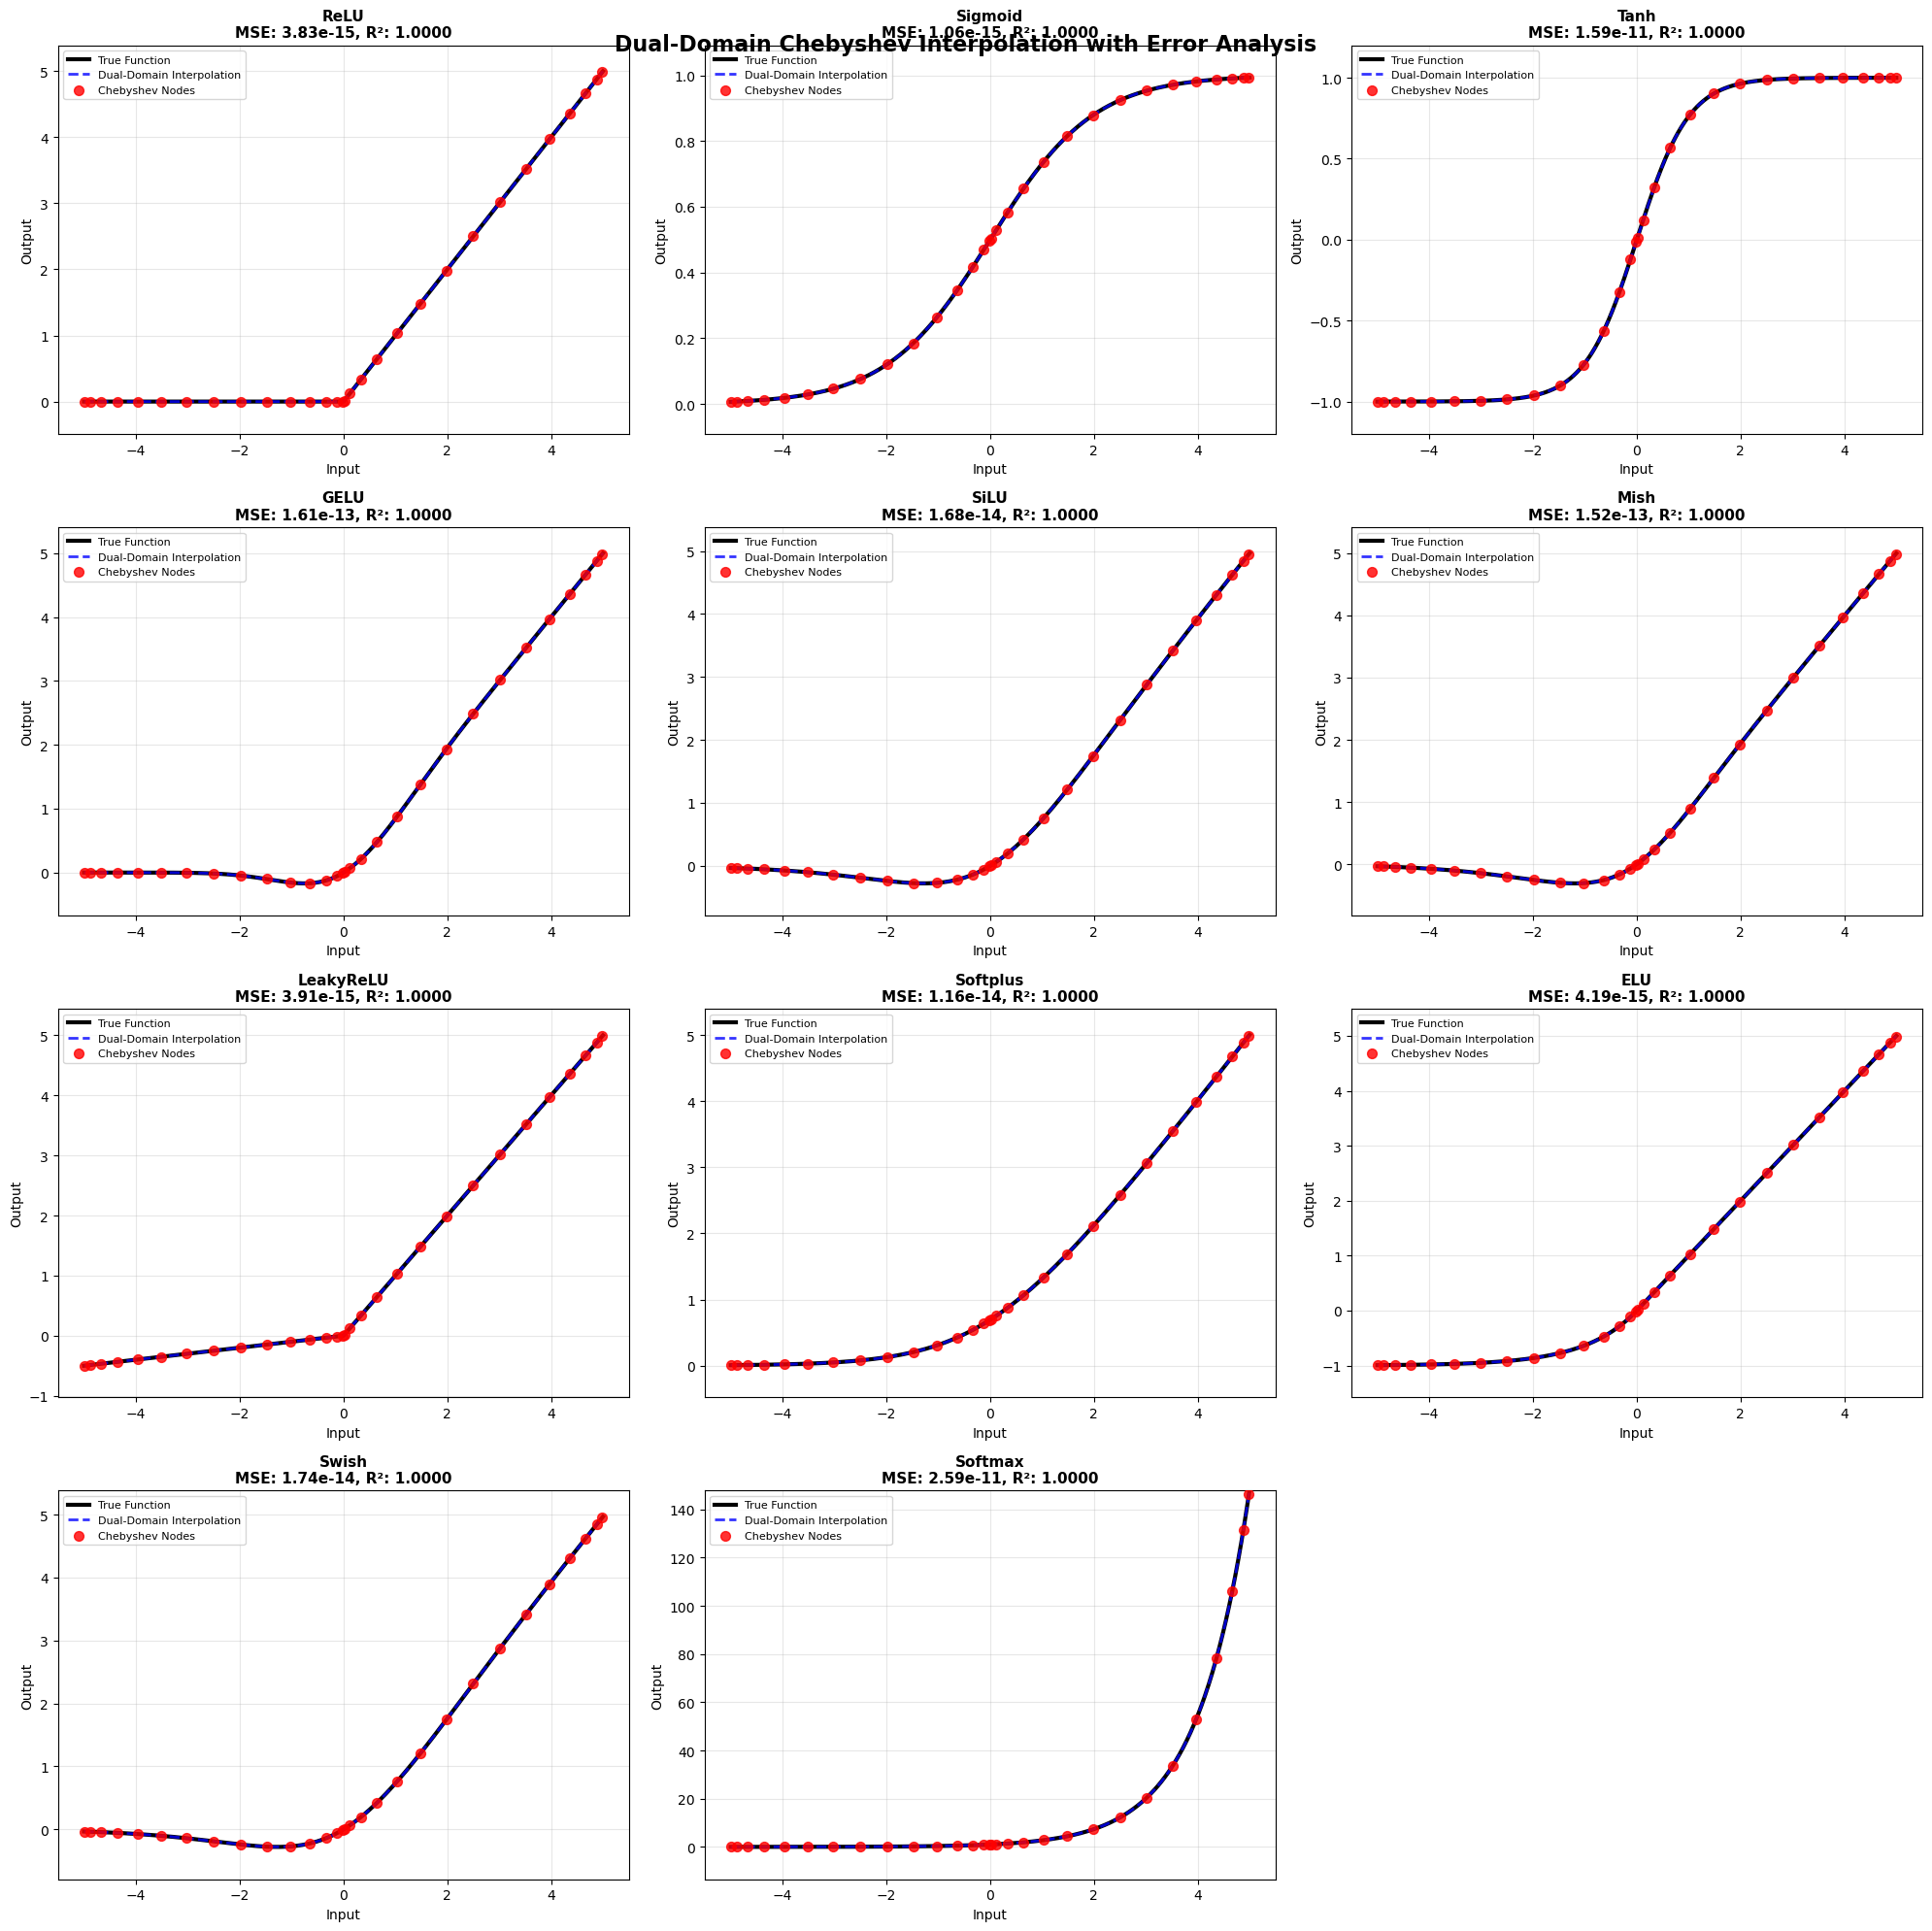


DETAILED ERROR ANALYSIS REPORT

1. OVERALL PERFORMANCE SUMMARY
--------------------------------------------------
+----+--------------+---------------+---------------+----------------+--------------+--------------------+
|    | Activation   |   Overall_MSE |   Overall_MAE |   Overall_RMSE |   Overall_R2 |   Overall_MaxError |
+====+==============+===============+===============+================+==============+====================+
|  0 | ReLU         |      0.00e+00 |      0.00e+00 |       0.00e+00 |     1.00e+00 |           0.00e+00 |
+----+--------------+---------------+---------------+----------------+--------------+--------------------+
|  1 | Sigmoid      |      0.00e+00 |      0.00e+00 |       0.00e+00 |     1.00e+00 |           0.00e+00 |
+----+--------------+---------------+---------------+----------------+--------------+--------------------+
|  2 | Tanh         |      0.00e+00 |      3.00e-06 |       4.00e-06 |     1.00e+00 |           1.00e-05 |
+----+--------------+--------

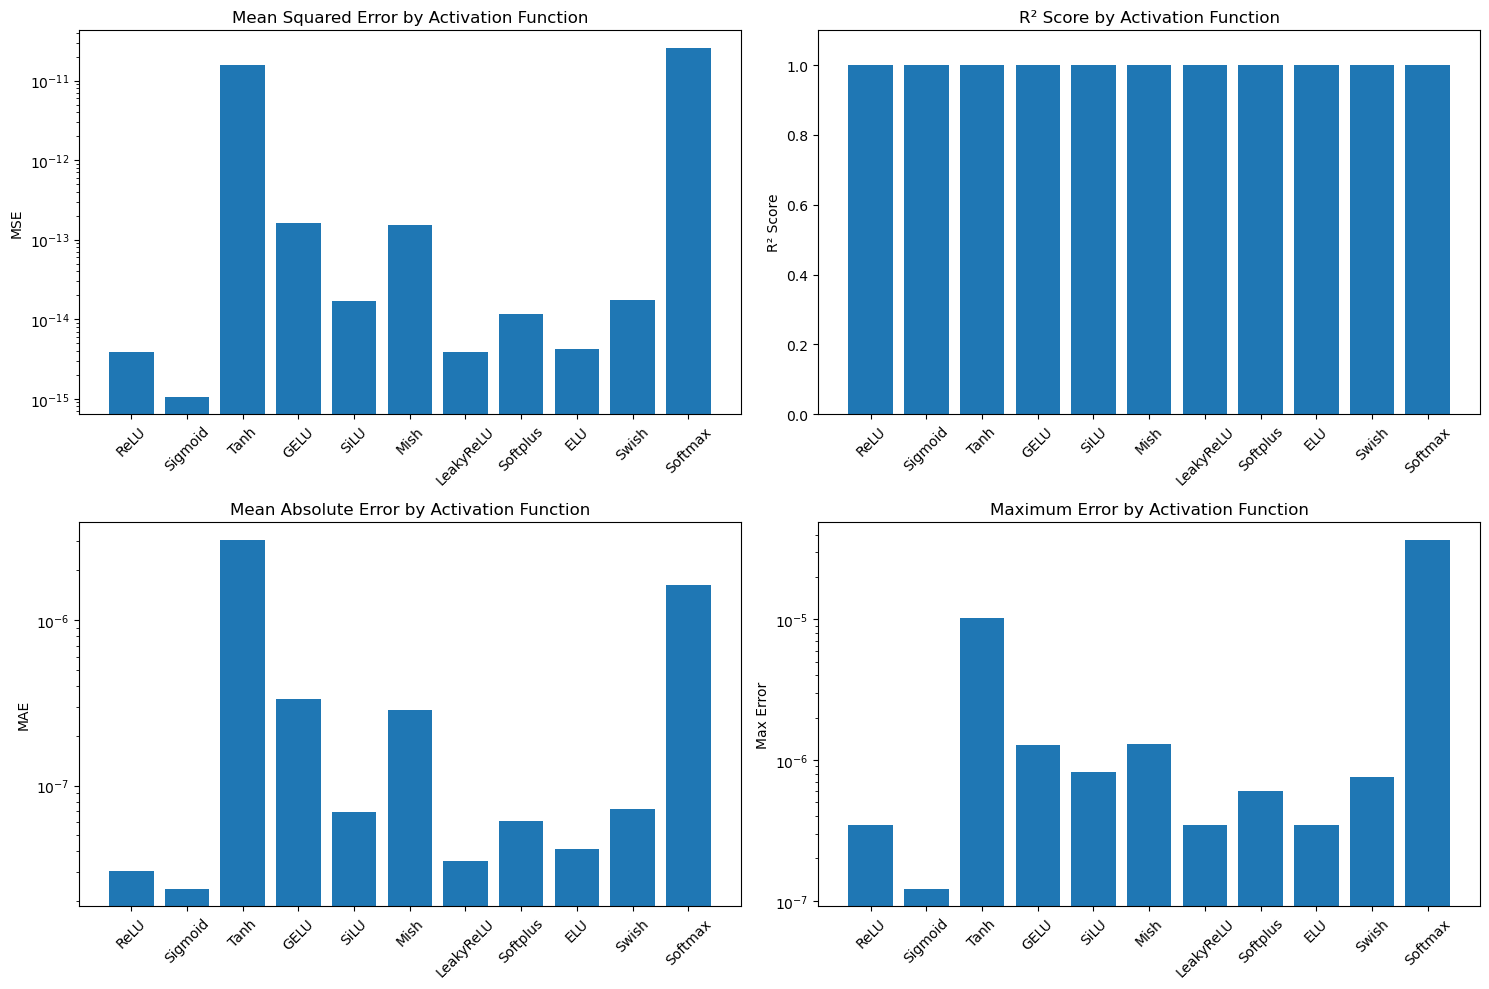


ANALYSIS COMPLETE


In [ ]:
# Piecewise Seperate Polynomials for Positive and Negative Domains of the Activation Functions with error metrics

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error
import pandas as pd
import seaborn as sns
from tabulate import tabulate

class ChebyshevActivationInterpolator:
    """Enhanced Chebyshev polynomial interpolator for activation functions with comprehensive error analysis"""
    
    def __init__(self, expansion_point=0.0):
        self.expansion_point = expansion_point
        self.coefficients = None
        self.degree = None
        self.x_train = None
        self.y_train = None
        self.training_error = None
        
    def _generate_chebyshev_nodes(self, a, b, n):
        """Generate Chebyshev nodes of the first kind on interval [a, b]"""
        i = np.arange(n)
        nodes_unit = np.cos((2 * i + 1) * np.pi / (2 * n))
        return 0.5 * (b - a) * nodes_unit + 0.5 * (b + a)
    
    def get_chebyshev_nodes(self):
        """Retrieve stored Chebyshev nodes"""
        return self.x_train.copy() if self.x_train is not None else None
    
    def _vandermonde_matrix(self, x, degree):
        """Construct shifted Vandermonde matrix with specified degree"""
        x_shifted = x - self.expansion_point
        return np.vander(x_shifted, N=degree+1, increasing=True)
    
    def fit(self, activation_fn, x_range=(-5, 5), n_points=50):
        """Fit exact interpolating polynomial using Chebyshev nodes with error tracking"""
        self.x_train = self._generate_chebyshev_nodes(x_range[0], x_range[1], n_points)
        
        x_torch = torch.tensor(self.x_train, dtype=torch.float32).unsqueeze(-1)
        self.y_train = activation_fn(x_torch).numpy().flatten()
        
        self.degree = len(self.x_train) - 1
        X = self._vandermonde_matrix(self.x_train, self.degree)
        
        try:
            self.coefficients = np.linalg.solve(X, self.y_train)
            # Calculate training error (should be near zero for exact interpolation)
            y_pred_train = self.predict(self.x_train)
            self.training_error = np.mean((self.y_train - y_pred_train) ** 2)
        except np.linalg.LinAlgError:
            # Fallback to least squares if matrix is singular
            self.coefficients = np.linalg.lstsq(X, self.y_train, rcond=None)[0]
            y_pred_train = self.predict(self.x_train)
            self.training_error = np.mean((self.y_train - y_pred_train) ** 2)
            
        return self
    
    def predict(self, x):
        """Evaluate interpolating polynomial"""
        if self.coefficients is None:
            raise ValueError("Model not fitted. Call fit() first.")
        X = self._vandermonde_matrix(x, self.degree)
        return X @ self.coefficients
    
    def evaluate_error_metrics(self, x_test, y_true):
        """Calculate comprehensive error metrics"""
        y_pred = self.predict(x_test)
        
        # Handle potential NaN or infinite values
        valid_mask = np.isfinite(y_pred) & np.isfinite(y_true)
        y_pred_clean = y_pred[valid_mask]
        y_true_clean = y_true[valid_mask]
        
        if len(y_pred_clean) == 0:
            return {
                'mse': float('inf'),
                'mae': float('inf'),
                'rmse': float('inf'),
                'r2': -float('inf'),
                'max_error': float('inf'),
                'mape': float('inf'),
                'valid_points': 0
            }
        
        metrics = {
            'mse': mean_squared_error(y_true_clean, y_pred_clean),
            'mae': mean_absolute_error(y_true_clean, y_pred_clean),
            'rmse': np.sqrt(mean_squared_error(y_true_clean, y_pred_clean)),
            'r2': r2_score(y_true_clean, y_pred_clean),
            'max_error': max_error(y_true_clean, y_pred_clean),
            'mape': np.mean(np.abs((y_true_clean - y_pred_clean) / (y_true_clean + 1e-8))) * 100,
            'valid_points': len(y_pred_clean)
        }
        
        return metrics
    
    def equation(self, precision=100):
        """Generate formatted polynomial equation"""
        if self.coefficients is None:
            return "Model not fitted"
            
        terms = []
        for i, coeff in enumerate(self.coefficients):
            if abs(coeff) < 1e-10:
                continue
            term = f"{coeff:.{precision}f}"
            if i > 0:
                if i == 1:
                    term += f"(x-{self.expansion_point})"
                else:
                    term += f"(x-{self.expansion_point})^{i}"
            terms.append(term)
        
        if not terms:
            return "0"
            
        equation = " + ".join(terms).replace("+ -", "- ")
        return equation

class DualDomainInterpolator:
    """Dual-domain interpolator managing separate interpolators for negative and positive domains"""
    
    def __init__(self):
        self.interp_neg = ChebyshevActivationInterpolator()
        self.interp_pos = ChebyshevActivationInterpolator()
        self.split_point = 0.0
        
    def fit(self, activation_fn, x_range=(-5, 5), n_points_per_domain=10):
        """Fit interpolators on both domains"""
        # Fit negative domain
        self.interp_neg.fit(activation_fn, x_range=(x_range[0], self.split_point), n_points=n_points_per_domain)
        # Fit positive domain  
        self.interp_pos.fit(activation_fn, x_range=(self.split_point, x_range[1]), n_points=n_points_per_domain)
        return self
    
    def predict(self, x):
        """Predict using appropriate domain interpolator"""
        x = np.asarray(x)
        y_pred = np.zeros_like(x)
        
        # Negative domain
        neg_mask = x < self.split_point
        if np.any(neg_mask):
            y_pred[neg_mask] = self.interp_neg.predict(x[neg_mask])
            
        # Positive domain
        pos_mask = x >= self.split_point
        if np.any(pos_mask):
            y_pred[pos_mask] = self.interp_pos.predict(x[pos_mask])
            
        return y_pred
    
    def evaluate_error_metrics(self, x_test, y_true):
        """Evaluate error metrics for the combined dual-domain interpolator"""
        y_pred = self.predict(x_test)
        
        # Overall metrics
        valid_mask = np.isfinite(y_pred) & np.isfinite(y_true)
        y_pred_clean = y_pred[valid_mask]
        y_true_clean = y_true[valid_mask]
        
        if len(y_pred_clean) == 0:
            return {
                'overall': {'mse': float('inf'), 'mae': float('inf'), 'rmse': float('inf'), 
                           'r2': -float('inf'), 'max_error': float('inf'), 'mape': float('inf')},
                'negative_domain': {},
                'positive_domain': {}
            }
        
        overall_metrics = {
            'mse': mean_squared_error(y_true_clean, y_pred_clean),
            'mae': mean_absolute_error(y_true_clean, y_pred_clean),
            'rmse': np.sqrt(mean_squared_error(y_true_clean, y_pred_clean)),
            'r2': r2_score(y_true_clean, y_pred_clean),
            'max_error': max_error(y_true_clean, y_pred_clean),
            'mape': np.mean(np.abs((y_true_clean - y_pred_clean) / (y_true_clean + 1e-8))) * 100
        }
        
        # Domain-specific metrics
        neg_mask = (x_test < self.split_point) & valid_mask
        pos_mask = (x_test >= self.split_point) & valid_mask
        
        neg_metrics = {}
        pos_metrics = {}
        
        if np.any(neg_mask):
            neg_metrics = self.interp_neg.evaluate_error_metrics(x_test[neg_mask], y_true[neg_mask])
            
        if np.any(pos_mask):
            pos_metrics = self.interp_pos.evaluate_error_metrics(x_test[pos_mask], y_true[pos_mask])
        
        return {
            'overall': overall_metrics,
            'negative_domain': neg_metrics,
            'positive_domain': pos_metrics
        }

# Enhanced activation function configuration
activation_config = {
    'ReLU': F.relu,
    'Sigmoid': torch.sigmoid,
    'Tanh': torch.tanh,
    'GELU': F.gelu,
    'SiLU': F.silu,
    'Mish': lambda x: x * torch.tanh(F.softplus(x)),
    'LeakyReLU': lambda x: F.leaky_relu(x, 0.1),
    'Softplus': F.softplus,
    'ELU': lambda x: F.elu(x, alpha=1.0),
    'Swish': lambda x: x * torch.sigmoid(x),
    'Softmax': lambda x: torch.exp(x)
}

def comprehensive_interpolation_analysis():
    """Comprehensive analysis with error metrics and enhanced visualization"""
    
    # Initialize results storage
    results_summary = []
    detailed_results = {}
    
    # Create visualization
    n_activations = len(activation_config)
    cols = 3
    rows = (n_activations + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, 5*rows))
    axes = axes.flatten() if n_activations > 1 else [axes]
    
    # Generate test data
    x_test = np.linspace(-5, 5, 1000)
    
    print("="*80)
    print("COMPREHENSIVE DUAL-DOMAIN CHEBYSHEV INTERPOLATION ANALYSIS")
    print("="*80)
    
    for idx, (name, fn) in enumerate(activation_config.items()):
        print(f"\nAnalyzing {name} activation function...")
        
        # Create and fit dual-domain interpolator
        dual_interp = DualDomainInterpolator()
        dual_interp.fit(fn, x_range=(-5, 5), n_points_per_domain=15)
        
        # Get true values and predictions
        y_true = fn(torch.tensor(x_test, dtype=torch.float32)).numpy()
        y_pred = dual_interp.predict(x_test)
        
        # Calculate error metrics
        error_metrics = dual_interp.evaluate_error_metrics(x_test, y_true)
        
        # Store results
        result_entry = {
            'Activation': name,
            'Overall_MSE': error_metrics['overall']['mse'],
            'Overall_MAE': error_metrics['overall']['mae'],
            'Overall_RMSE': error_metrics['overall']['rmse'],
            'Overall_R2': error_metrics['overall']['r2'],
            'Overall_MaxError': error_metrics['overall']['max_error'],
            'Overall_MAPE': error_metrics['overall']['mape']
        }
        
        # Add domain-specific metrics if available
        if error_metrics['negative_domain']:
            result_entry.update({
                'Neg_MSE': error_metrics['negative_domain']['mse'],
                'Neg_R2': error_metrics['negative_domain']['r2']
            })
        if error_metrics['positive_domain']:
            result_entry.update({
                'Pos_MSE': error_metrics['positive_domain']['mse'],
                'Pos_R2': error_metrics['positive_domain']['r2']
            })
            
        results_summary.append(result_entry)
        detailed_results[name] = error_metrics
        
        # Visualization
        if idx < len(axes):
            ax = axes[idx]
            
            # Plot true function and interpolation
            ax.plot(x_test, y_true, label='True Function', linewidth=3, color='black')
            ax.plot(x_test, y_pred, '--', label='Dual-Domain Interpolation', 
                   linewidth=2, color='blue', alpha=0.8)
            
            # Plot Chebyshev nodes
            nodes_neg = dual_interp.interp_neg.get_chebyshev_nodes()
            nodes_pos = dual_interp.interp_pos.get_chebyshev_nodes()
            
            if nodes_neg is not None:
                y_nodes_neg = fn(torch.tensor(nodes_neg, dtype=torch.float32)).numpy()
                ax.scatter(nodes_neg, y_nodes_neg, color='red', s=50, zorder=5, 
                          label='Chebyshev Nodes', alpha=0.8)
                          
            if nodes_pos is not None:
                y_nodes_pos = fn(torch.tensor(nodes_pos, dtype=torch.float32)).numpy()
                ax.scatter(nodes_pos, y_nodes_pos, color='red', s=50, zorder=5, alpha=0.8)
            
            # Add error information to plot
            mse = error_metrics['overall']['mse']
            r2 = error_metrics['overall']['r2']
            
            ax.set_title(f"{name}\nMSE: {mse:.2e}, R²: {r2:.4f}", 
                        fontweight='bold', fontsize=11)
            ax.set_xlabel("Input", fontsize=10)
            ax.set_ylabel("Output", fontsize=10)
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=8)
            
            # Set reasonable y-limits
            y_min, y_max = np.percentile(y_true, [1, 99])
            y_range = y_max - y_min
            ax.set_ylim([y_min - 0.1*y_range, y_max + 0.1*y_range])
    
    # Hide unused subplots
    for idx in range(len(activation_config), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.suptitle("Dual-Domain Chebyshev Interpolation with Error Analysis", 
                 y=0.98, fontsize=16, fontweight='bold')
    plt.show()
    
    return results_summary, detailed_results

def generate_error_analysis_report(results_summary, detailed_results):
    """Generate comprehensive error analysis report"""
    
    print("\n" + "="*100)
    print("DETAILED ERROR ANALYSIS REPORT")
    print("="*100)
    
    # Convert results to DataFrame for better analysis
    df_results = pd.DataFrame(results_summary)
    
    # Summary statistics table
    print("\n1. OVERALL PERFORMANCE SUMMARY")
    print("-" * 50)
    
    summary_cols = ['Overall_MSE', 'Overall_MAE', 'Overall_RMSE', 'Overall_R2', 'Overall_MaxError']
    summary_stats = df_results[['Activation'] + summary_cols].round(6)
    
    print(tabulate(summary_stats, headers=summary_stats.columns, tablefmt='grid', floatfmt='.2e'))
    
    # Best and worst performers
    print("\n2. PERFORMANCE RANKINGS")
    print("-" * 30)
    
    best_mse = df_results.loc[df_results['Overall_MSE'].idxmin(), 'Activation']
    worst_mse = df_results.loc[df_results['Overall_MSE'].idxmax(), 'Activation']
    best_r2 = df_results.loc[df_results['Overall_R2'].idxmax(), 'Activation']
    worst_r2 = df_results.loc[df_results['Overall_R2'].idxmin(), 'Activation']
    
    print(f"Best MSE (lowest):     {best_mse} ({df_results['Overall_MSE'].min():.2e})")
    print(f"Worst MSE (highest):   {worst_mse} ({df_results['Overall_MSE'].max():.2e})")
    print(f"Best R² (highest):     {best_r2} ({df_results['Overall_R2'].max():.4f})")
    print(f"Worst R² (lowest):     {worst_r2} ({df_results['Overall_R2'].min():.4f})")
    
    # Statistical summary
    print("\n3. STATISTICAL SUMMARY OF ERROR METRICS")
    print("-" * 45)
    
    stats_summary = df_results[summary_cols].describe()
    print(tabulate(stats_summary, headers=stats_summary.columns, tablefmt='grid', floatfmt='.2e'))
    
    # Domain-specific analysis
    print("\n4. DOMAIN-SPECIFIC ANALYSIS")
    print("-" * 35)
    
    for name, metrics in detailed_results.items():
        print(f"\n{name.upper()}:")
        print(f"  Overall MSE: {metrics['overall']['mse']:.2e}")
        
        if metrics['negative_domain']:
            print(f"  Negative Domain MSE: {metrics['negative_domain']['mse']:.2e}")
            print(f"  Negative Domain R²:  {metrics['negative_domain']['r2']:.4f}")
            
        if metrics['positive_domain']:
            print(f"  Positive Domain MSE: {metrics['positive_domain']['mse']:.2e}")
            print(f"  Positive Domain R²:  {metrics['positive_domain']['r2']:.4f}")

def create_error_visualization(results_summary):
    """Create comprehensive error visualization"""
    
    df_results = pd.DataFrame(results_summary)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # MSE comparison
    axes[0,0].bar(df_results['Activation'], df_results['Overall_MSE'])
    axes[0,0].set_title('Mean Squared Error by Activation Function')
    axes[0,0].set_ylabel('MSE')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].set_yscale('log')
    
    # R² comparison
    axes[0,1].bar(df_results['Activation'], df_results['Overall_R2'])
    axes[0,1].set_title('R² Score by Activation Function')
    axes[0,1].set_ylabel('R² Score')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].set_ylim([0, 1.1])
    
    # MAE comparison
    axes[1,0].bar(df_results['Activation'], df_results['Overall_MAE'])
    axes[1,0].set_title('Mean Absolute Error by Activation Function')
    axes[1,0].set_ylabel('MAE')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].set_yscale('log')
    
    # Max Error comparison
    axes[1,1].bar(df_results['Activation'], df_results['Overall_MaxError'])
    axes[1,1].set_title('Maximum Error by Activation Function')
    axes[1,1].set_ylabel('Max Error')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].set_yscale('log')
    
    plt.tight_layout()
    plt.show()

# Main execution function
def main():
    """Main execution with comprehensive analysis"""
    print("Starting comprehensive dual-domain Chebyshev interpolation analysis...")
    
    # Run comprehensive analysis
    results_summary, detailed_results = comprehensive_interpolation_analysis()
    
    # Generate detailed report
    generate_error_analysis_report(results_summary, detailed_results)
    
    # Create error visualization
    create_error_visualization(results_summary)
    
    print("\n" + "="*80)
    print("ANALYSIS COMPLETE")
    print("="*80)
    
    return results_summary, detailed_results

# Execute the enhanced analysis
if __name__ == "__main__":
    results_summary, detailed_results = main()



ReLU Activation Function Equations:
Segment 1 (-5.00 ≤ x < -4.00): y = 0.0000 + -0.0000(x - -5.00)
Segment 2 (-4.00 ≤ x < -3.00): y = 0.0000 + -0.0000(x - -4.00)
Segment 3 (-3.00 ≤ x < -2.00): y = 0.0000 + -0.0000(x - -3.00)
Segment 4 (-2.00 ≤ x < -1.00): y = 0.0000 + -0.0000(x - -2.00)
Segment 5 (-1.00 ≤ x < 0.00): y = 0.0000 + -0.0000(x - -1.00)
Segment 6 (0.00 ≤ x < 1.00): y = 0.0000 + 1.0000(x - 0.00)
Segment 7 (1.00 ≤ x < 2.00): y = 1.0000 + 1.0000(x - 1.00)
Segment 8 (2.00 ≤ x < 3.00): y = 2.0000 + 1.0000(x - 2.00)
Segment 9 (3.00 ≤ x < 4.00): y = 3.0000 + 1.0000(x - 3.00)
Segment 10 (4.00 ≤ x < 5.00): y = 4.0000 + 1.0000(x - 4.00)

Sigmoid Activation Function Equations:
Segment 1 (-5.00 ≤ x < -4.00): y = 0.0061 + 0.0111(x - -5.00)
Segment 2 (-4.00 ≤ x < -3.00): y = 0.0165 + 0.0289(x - -4.00)
Segment 3 (-3.00 ≤ x < -2.00): y = 0.0441 + 0.0709(x - -3.00)
Segment 4 (-2.00 ≤ x < -1.00): y = 0.1136 + 0.1495(x - -2.00)
Segment 5 (-1.00 ≤ x < 0.00): y = 0.2646 + 0.2330(x - -1.00)
Segm

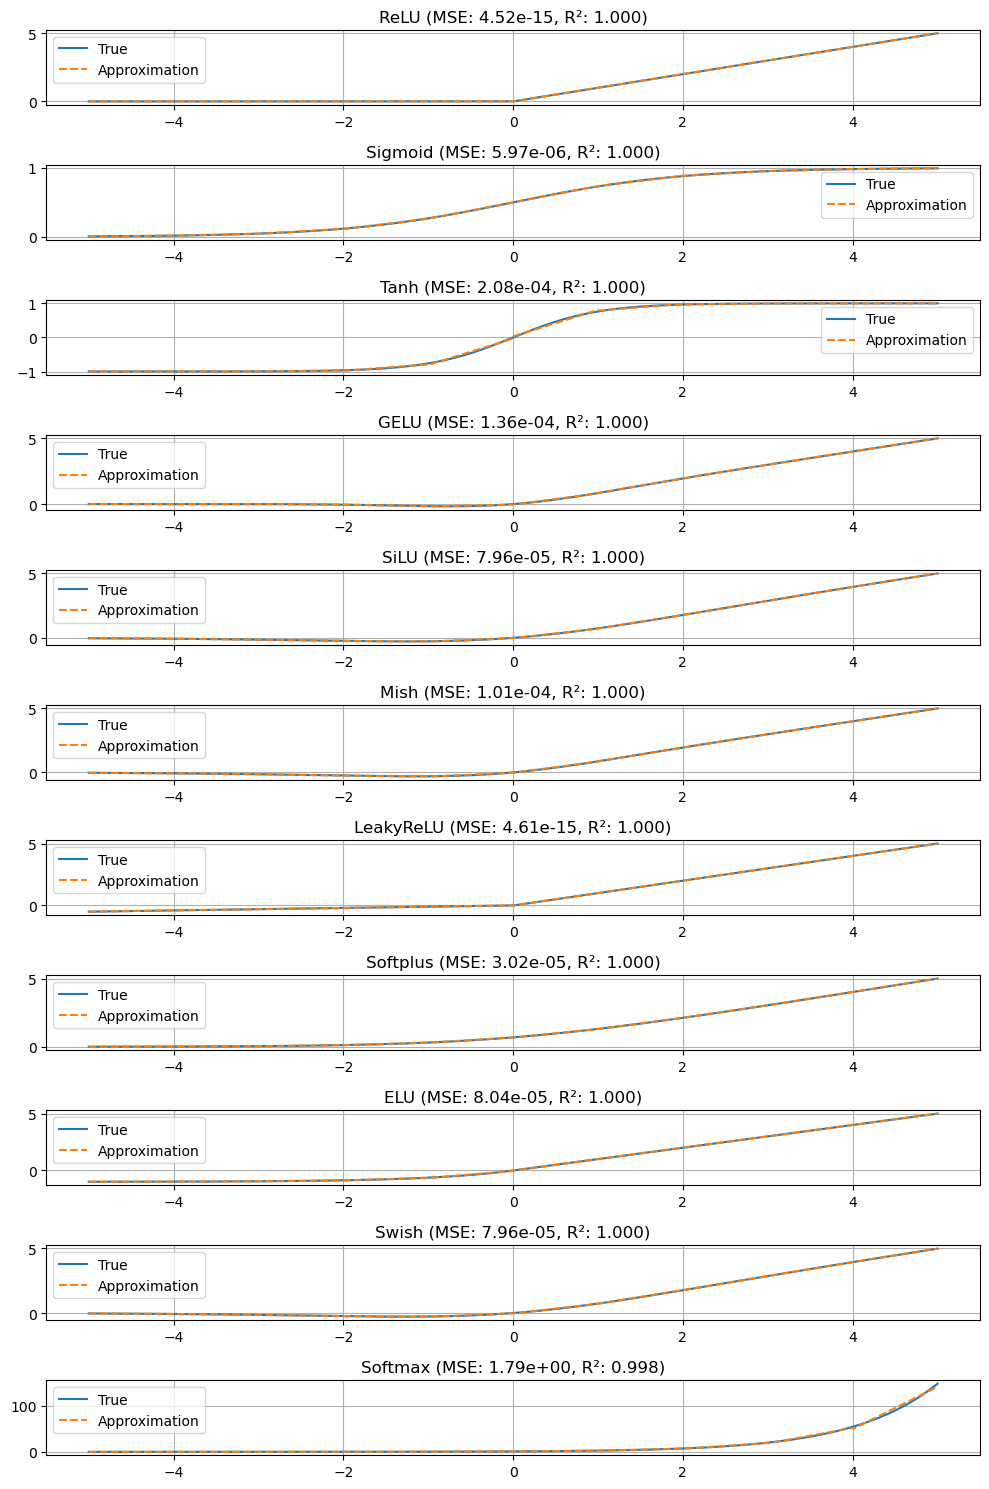


Performance Summary:
+----+--------------+----------+----------+----------+
|    | Activation   |      MSE |      MAE |       R² |
+====+==============+==========+==========+==========+
|  0 | ReLU         | 4.52e-15 | 3.39e-08 | 1.00e+00 |
+----+--------------+----------+----------+----------+
|  1 | Sigmoid      | 5.97e-06 | 1.88e-03 | 1.00e+00 |
+----+--------------+----------+----------+----------+
|  2 | Tanh         | 2.08e-04 | 8.14e-03 | 1.00e+00 |
+----+--------------+----------+----------+----------+
|  3 | GELU         | 1.36e-04 | 5.47e-03 | 1.00e+00 |
+----+--------------+----------+----------+----------+
|  4 | SiLU         | 7.96e-05 | 5.07e-03 | 1.00e+00 |
+----+--------------+----------+----------+----------+
|  5 | Mish         | 1.01e-04 | 5.13e-03 | 1.00e+00 |
+----+--------------+----------+----------+----------+
|  6 | LeakyReLU    | 4.61e-15 | 3.88e-08 | 1.00e+00 |
+----+--------------+----------+----------+----------+
|  7 | Softplus     | 3.02e-05 | 3.76e-03 |

In [15]:
# Piecewise Curvefitting to make the polynomial per piece of each activation function linear

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tabulate import tabulate

class ChebyshevActivationInterpolator:
    def __init__(self, expansion_point=0.0):
        self.expansion_point = expansion_point
        self.coefficients = None

    def _generate_chebyshev_nodes(self, a, b, n):
        i = np.arange(n)
        nodes = np.cos((2*i + 1)*np.pi/(2*n))
        return 0.5*(b - a)*nodes + 0.5*(a + b)

    def fit(self, activation_fn, x_range, n_points=2):
        x_train = self._generate_chebyshev_nodes(x_range[0], x_range[1], n_points)
        x_torch = torch.tensor(x_train, dtype=torch.float32).unsqueeze(-1)
        y_train = activation_fn(x_torch).numpy().flatten()
        
        X = np.column_stack([np.ones_like(x_train), x_train - self.expansion_point])
        self.coefficients = np.linalg.solve(X, y_train)
        return self

    def predict(self, x):
        X = np.column_stack([np.ones_like(x), x - self.expansion_point])
        return X @ self.coefficients

class MultiDomainInterpolator:
    def __init__(self, g=10):
        self.g = g
        self.segment_interpolators = []
        self.segment_ranges = []

    def fit(self, activation_fn, x_range=(-5, 5)):
        a, b = x_range
        segment_width = (b - a)/self.g
        self.segment_interpolators = []
        self.segment_ranges = []
        
        for i in range(self.g):
            seg_start = a + i*segment_width
            seg_end = seg_start + segment_width
            if i == self.g - 1:
                seg_end = b
                
            interpolator = ChebyshevActivationInterpolator(seg_start)
            interpolator.fit(activation_fn, (seg_start, seg_end))
            self.segment_interpolators.append(interpolator)
            self.segment_ranges.append((seg_start, seg_end))
        return self

    def predict(self, x):
        x = np.asarray(x)
        y_pred = np.zeros_like(x)
        for i, (seg_start, seg_end) in enumerate(self.segment_ranges):
            mask = (x >= seg_start) & (x < seg_end) if i < self.g-1 else (x >= seg_start)
            if np.any(mask):
                y_pred[mask] = self.segment_interpolators[i].predict(x[mask])
        return y_pred

    def get_equations(self):
        equations = []
        for i, interp in enumerate(self.segment_interpolators):
            seg_start, seg_end = self.segment_ranges[i]
            a0, a1 = interp.coefficients
            equations.append(f"Segment {i+1} ({seg_start:.2f} ≤ x < {seg_end:.2f}): y = {a0:.4f} + {a1:.4f}(x - {seg_start:.2f})")
        return equations

activation_config = {
    'ReLU': F.relu,
    'Sigmoid': torch.sigmoid,
    'Tanh': torch.tanh,
    'GELU': F.gelu,
    'SiLU': F.silu,
    'Mish': lambda x: x * torch.tanh(F.softplus(x)),
    'LeakyReLU': lambda x: F.leaky_relu(x, 0.1),
    'Softplus': F.softplus,
    'ELU': lambda x: F.elu(x, alpha=1.0),
    'Swish': lambda x: x * torch.sigmoid(x),
    'Softmax': lambda x: torch.exp(x)
}

def comprehensive_analysis(g_segments=10):
    results = []
    x_test = np.linspace(-5, 5, 1000)
    fig, axes = plt.subplots(len(activation_config), 1, figsize=(10, 15))
    
    for idx, (name, fn) in enumerate(activation_config.items()):
        interpolator = MultiDomainInterpolator(g_segments)
        interpolator.fit(fn)
        y_true = fn(torch.tensor(x_test, dtype=torch.float32)).numpy()
        y_pred = interpolator.predict(x_test)
        
        print(f"\n{name} Activation Function Equations:")
        for eq in interpolator.get_equations():
            print(eq)
            
        metrics = {
            'Activation': name,
            'MSE': mean_squared_error(y_true, y_pred),
            'MAE': mean_absolute_error(y_true, y_pred),
            'R²': r2_score(y_true, y_pred)
        }
        results.append(metrics)
        
        ax = axes[idx]
        ax.plot(x_test, y_true, label='True')
        ax.plot(x_test, y_pred, '--', label='Approximation')
        ax.set_title(f"{name} (MSE: {metrics['MSE']:.2e}, R²: {metrics['R²']:.3f})")
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()
    return pd.DataFrame(results)

results_df = comprehensive_analysis(g_segments=10)
print("\nPerformance Summary:")
print(tabulate(results_df, headers='keys', tablefmt='grid', floatfmt=".2e"))



ReLU Activation Function Equations:
Segment 1 (-5.00 ≤ x < -4.90): y = 0.0000 + -0.0000(x - -5.00)
Segment 2 (-4.90 ≤ x < -4.80): y = 0.0000 + -0.0000(x - -4.90)
Segment 3 (-4.80 ≤ x < -4.70): y = 0.0000 + -0.0000(x - -4.80)
Segment 4 (-4.70 ≤ x < -4.60): y = 0.0000 + -0.0000(x - -4.70)
Segment 5 (-4.60 ≤ x < -4.50): y = 0.0000 + -0.0000(x - -4.60)
Segment 6 (-4.50 ≤ x < -4.40): y = 0.0000 + -0.0000(x - -4.50)
Segment 7 (-4.40 ≤ x < -4.30): y = 0.0000 + -0.0000(x - -4.40)
Segment 8 (-4.30 ≤ x < -4.20): y = 0.0000 + -0.0000(x - -4.30)
Segment 9 (-4.20 ≤ x < -4.10): y = 0.0000 + -0.0000(x - -4.20)
Segment 10 (-4.10 ≤ x < -4.00): y = 0.0000 + -0.0000(x - -4.10)
Segment 11 (-4.00 ≤ x < -3.90): y = 0.0000 + -0.0000(x - -4.00)
Segment 12 (-3.90 ≤ x < -3.80): y = 0.0000 + -0.0000(x - -3.90)
Segment 13 (-3.80 ≤ x < -3.70): y = 0.0000 + -0.0000(x - -3.80)
Segment 14 (-3.70 ≤ x < -3.60): y = 0.0000 + -0.0000(x - -3.70)
Segment 15 (-3.60 ≤ x < -3.50): y = 0.0000 + -0.0000(x - -3.60)
Segment 16 (

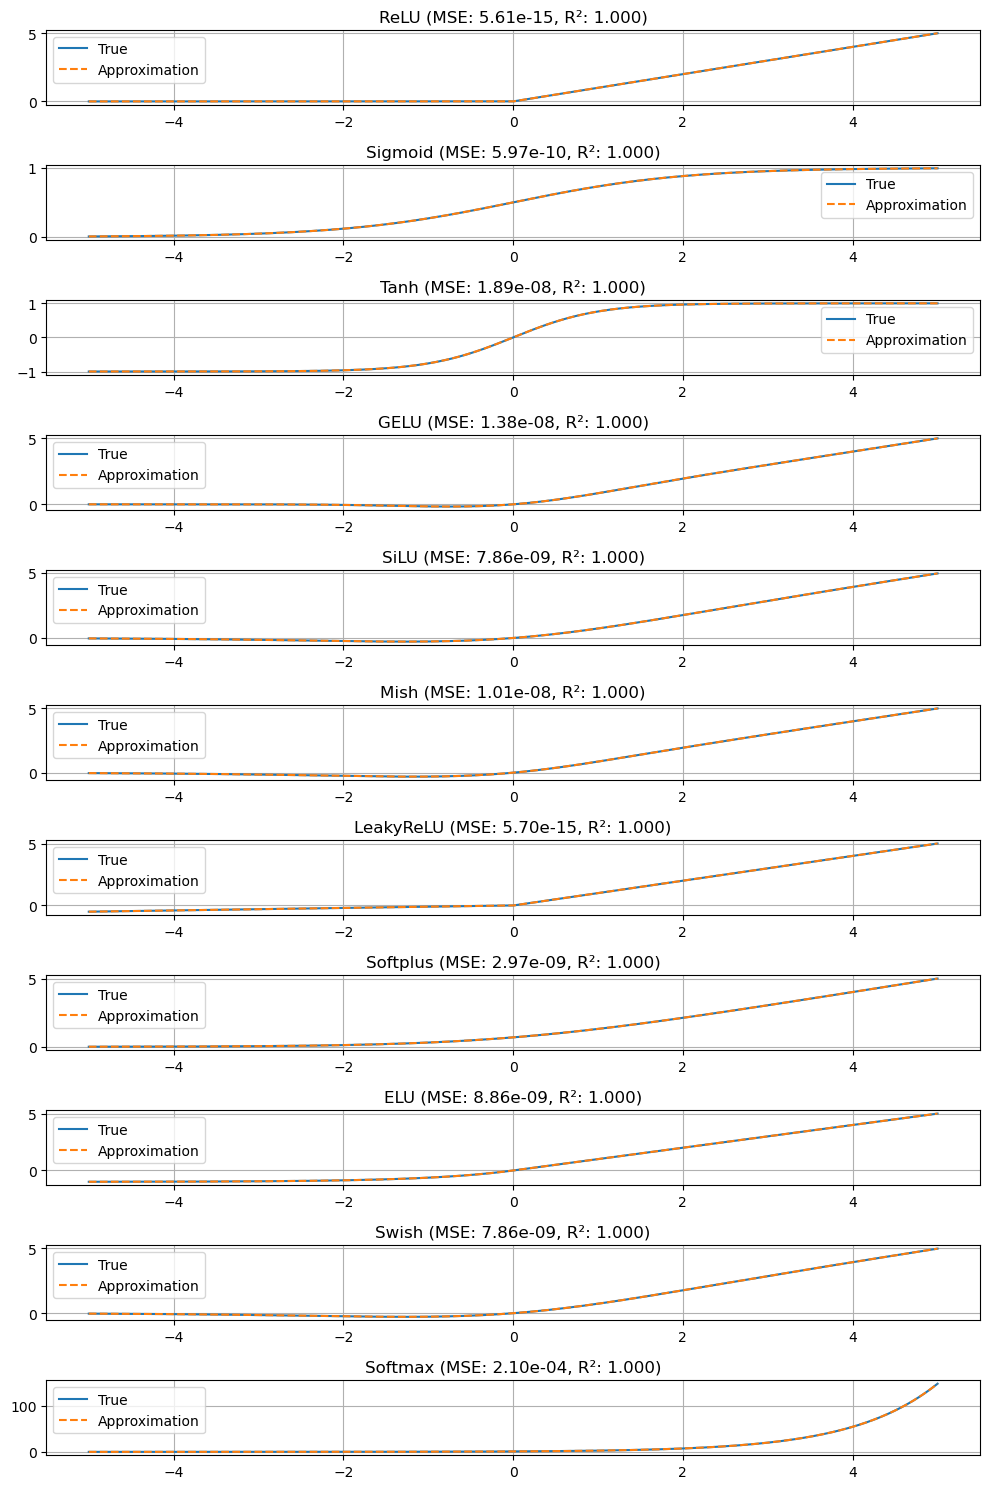


Performance Summary:
+----+--------------+----------+----------+----------+
|    | Activation   |      MSE |      MAE |       R² |
+====+==============+==========+==========+==========+
|  0 | ReLU         | 5.61e-15 | 3.60e-08 | 1.00e+00 |
+----+--------------+----------+----------+----------+
|  1 | Sigmoid      | 5.97e-10 | 1.84e-05 | 1.00e+00 |
+----+--------------+----------+----------+----------+
|  2 | Tanh         | 1.89e-08 | 7.44e-05 | 1.00e+00 |
+----+--------------+----------+----------+----------+
|  3 | GELU         | 1.38e-08 | 5.62e-05 | 1.00e+00 |
+----+--------------+----------+----------+----------+
|  4 | SiLU         | 7.86e-09 | 5.01e-05 | 1.00e+00 |
+----+--------------+----------+----------+----------+
|  5 | Mish         | 1.01e-08 | 5.10e-05 | 1.00e+00 |
+----+--------------+----------+----------+----------+
|  6 | LeakyReLU    | 5.70e-15 | 4.08e-08 | 1.00e+00 |
+----+--------------+----------+----------+----------+
|  7 | Softplus     | 2.97e-09 | 3.69e-05 |

In [ ]:
# Piecewise Curvefitting to make the polynomial per piece of each activation function linear with more segments to reduce the curvefit error...

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tabulate import tabulate

class ChebyshevActivationInterpolator:
    def __init__(self, expansion_point=0.0):
        self.expansion_point = expansion_point
        self.coefficients = None

    def _generate_chebyshev_nodes(self, a, b, n):
        i = np.arange(n)
        nodes = np.cos((2*i + 1)*np.pi/(2*n))
        return 0.5*(b - a)*nodes + 0.5*(a + b)

    def fit(self, activation_fn, x_range, n_points=2):
        x_train = self._generate_chebyshev_nodes(x_range[0], x_range[1], n_points)
        x_torch = torch.tensor(x_train, dtype=torch.float32).unsqueeze(-1)
        y_train = activation_fn(x_torch).numpy().flatten()
        
        X = np.column_stack([np.ones_like(x_train), x_train - self.expansion_point])
        self.coefficients = np.linalg.solve(X, y_train)
        return self

    def predict(self, x):
        X = np.column_stack([np.ones_like(x), x - self.expansion_point])
        return X @ self.coefficients

class MultiDomainInterpolator:
    def __init__(self, g=100):
        self.g = g
        self.segment_interpolators = []
        self.segment_ranges = []

    def fit(self, activation_fn, x_range=(-5, 5)):
        a, b = x_range
        segment_width = (b - a)/self.g
        self.segment_interpolators = []
        self.segment_ranges = []
        
        for i in range(self.g):
            seg_start = a + i*segment_width
            seg_end = seg_start + segment_width
            if i == self.g - 1:
                seg_end = b
                
            interpolator = ChebyshevActivationInterpolator(seg_start)
            interpolator.fit(activation_fn, (seg_start, seg_end))
            self.segment_interpolators.append(interpolator)
            self.segment_ranges.append((seg_start, seg_end))
        return self

    def predict(self, x):
        x = np.asarray(x)
        y_pred = np.zeros_like(x)
        for i, (seg_start, seg_end) in enumerate(self.segment_ranges):
            mask = (x >= seg_start) & (x < seg_end) if i < self.g-1 else (x >= seg_start)
            if np.any(mask):
                y_pred[mask] = self.segment_interpolators[i].predict(x[mask])
        return y_pred

    def get_equations(self):
        equations = []
        for i, interp in enumerate(self.segment_interpolators):
            seg_start, seg_end = self.segment_ranges[i]
            a0, a1 = interp.coefficients
            equations.append(f"Segment {i+1} ({seg_start:.2f} ≤ x < {seg_end:.2f}): y = {a0:.4f} + {a1:.4f}(x - {seg_start:.2f})")
        return equations

activation_config = {
    'ReLU': F.relu,
    'Sigmoid': torch.sigmoid,
    'Tanh': torch.tanh,
    'GELU': F.gelu,
    'SiLU': F.silu,
    'Mish': lambda x: x * torch.tanh(F.softplus(x)),
    'LeakyReLU': lambda x: F.leaky_relu(x, 0.1),
    'Softplus': F.softplus,
    'ELU': lambda x: F.elu(x, alpha=1.0),
    'Swish': lambda x: x * torch.sigmoid(x),
    'Softmax': lambda x: torch.exp(x)
}

def comprehensive_analysis(g_segments=100):
    results = []
    x_test = np.linspace(-5, 5, 1000)
    fig, axes = plt.subplots(len(activation_config), 1, figsize=(10, 15))
    
    for idx, (name, fn) in enumerate(activation_config.items()):
        interpolator = MultiDomainInterpolator(g_segments)
        interpolator.fit(fn)
        y_true = fn(torch.tensor(x_test, dtype=torch.float32)).numpy()
        y_pred = interpolator.predict(x_test)
        
        print(f"\n{name} Activation Function Equations:")
        for eq in interpolator.get_equations():
            print(eq)
            
        metrics = {
            'Activation': name,
            'MSE': mean_squared_error(y_true, y_pred),
            'MAE': mean_absolute_error(y_true, y_pred),
            'R²': r2_score(y_true, y_pred)
        }
        results.append(metrics)
        
        ax = axes[idx]
        ax.plot(x_test, y_true, label='True')
        ax.plot(x_test, y_pred, '--', label='Approximation')
        ax.set_title(f"{name} (MSE: {metrics['MSE']:.2e}, R²: {metrics['R²']:.3f})")
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()
    return pd.DataFrame(results)

results_df = comprehensive_analysis(g_segments=100)
print("\nPerformance Summary:")
print(tabulate(results_df, headers='keys', tablefmt='grid', floatfmt=".2e"))
